### Data Pruning for Fe Dataset

This notebook performs data pruning for the Fe dataset using the MEAGraph autoencoder model. The steps involved are:

1. **MEAGraph Autoencoder Training:**
  - Train the MEAGraph autoencoder on the Fe dataset.

2. **Inference:**
  - Specify the groups of data as the dataset for pruning (check available group names in `JSON` folder. e.g., using all groups).
  - Split the dataset into training and testing sets for subsequent ridge regression training (using a fixed random seed for reproducibility).  
  - Cluster the training dataset using the saved MEAGraph model (located in the `results` folder) to identify atomic clusters.

3. **Data Pruning:**
  - After MEAGraph inference, prune the training dataset by randomly removing a certain fraction (ranging from 0 to 100%) of atoms from the clusters of different size range. The cluster size ranges are determined by fitting the distribution of all cluster sizes to Gaussian Mixture Model.
  - Perform 20 random sampling iterations at each pruning fraction to ensure robustness.

4. **Ridge Regression Force Fitting:**
  - At each pruning fraction, train a ridge regression model on the pruned training dataset to fit the atomic forces.
  - Evaluate the trained ridge regression model by predicting forces for the test dataset (specified in step 2).

5. **Select a proper threhold value (`size_threshold`) for GAE pruning**
  - Select the one or a few cluster size ranges with most atoms for the pruning (e.g., three cluster size ranges of (14, 23), (24,38),(1008) in this example) and compare with random pruning
#### 1. GAE Training

- Specify the config settings in the yaml file in `configs` folder (e.g., device: gpu or cpu)
- Run `python main.py --cfg configs/user-defined-config.yaml` in the terminal or submit the job to the cluster if available

In [52]:
import os
import subprocess
# Get the current working directory
#current_dir=os.getcwd()
#Uncomment to specify the absolute path if `os.getcwd` not working
current_dir = f"/usr/workspace/sun36/MEAGraph/run/applications/DataPruning/Fe"  # change it to your working directory

# Change the working directory to "run_dir"
main_dir = os.path.abspath(os.path.join(current_dir, "..", "..",".."))
yaml_file='Fe_snap_all'
os.chdir(main_dir)

# Run GAE training (if not working try to run it in the terminal or submit the job to the cluster )
command=f'python main.py --cfg configs/{yaml_file}.yaml'
#subprocess.run(command,shell=True)

#### 2. Inference 

  - Specify the groups of data as the dataset for pruning (check available group names in `JSON` folder)
  - run `python inference.py`


In [53]:
import numpy as np
import umap
import pickle
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import os
import subprocess
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import torch,json
import pandas as pd
import yaml
import glob
os.chdir(current_dir)
# Set parameters
JSON_dir=f'{current_dir}/JSON'
group_names=[file.split('/')[-1] for file in glob.glob(f'{JSON_dir}/*')]
group_name_strs="+".join(group_names)

group_name_list=[group_name_strs]
print(group_name_list)
yaml_file='Fe_snap_all'
fixed_rate_l=0.9  #Edge similarity rate of build_graph function
rate=0.7     #'self-defined pooling rate for edge_reduction in Encoder layers'
train_val_ratio=0.7 #'ratio of training data to test data for the force field fitting using inference.py'
alpha=0.8   #alpha value used in ridge regression model

new_columns = {0: 'cluster_idx', 1: 'cluster_size'}
gs = GridSpec(1, 3, width_ratios=[1,1,1], height_ratios=[1])

# Load the config YAML file
with open(f'{main_dir}/configs/{yaml_file}.yaml', "r") as file:
    config = yaml.safe_load(file)
# Get the name of 'test_dir' to store the results of this inference
test_dir = config['test']['xyz_dir']

#set paths
results_dir=f"{main_dir}/results/{yaml_file}/{test_dir}"
jsonfile_path=f"{results_dir}/clusters_{group_name_strs}_r{rate}_train{train_val_ratio}.json"

# Run inference.py if the JSON file doesn't exist
if not os.path.exists(jsonfile_path):
    os.chdir(main_dir)
    command=f'python inference.py --cfg configs/{yaml_file}.yaml --rate {rate} --fixed_rate_l {fixed_rate_l}  --train_val_ratio {train_val_ratio} --group_name {group_name_strs} --device cpu'
    # subprocess.run(command,shell=True)
    os.chdir(current_dir)

['BCC-HCP-transition+CCMC-bcc-hcp-elastic_Jun2020+EOS_001_Jun2020+EOS_100+MD-bcc_Te300K+liquid_mag_old+liquid_nonmag+point_def']


- Combine the clustering results (cluster_idx, cluster_size), per-atom feature, force truths to a single dataframe for the following potential fitting

In [54]:

# Load data
traindata=torch.load(f"{results_dir}/graph_{group_name_strs}_train{train_val_ratio}_data.pt")
testdata=torch.load(f"{results_dir}//graph_{group_name_strs}_train{train_val_ratio}_testdata.pt")
num_feats=int(traindata.x.size(1)/3)

# save the data.labels to df_labels dataframe, data.labels includes info about Group and Config names
concat_datalabels = [item for sublist in traindata.labels for item in sublist]
df_labels = pd.DataFrame(concat_datalabels)
df_labels.reset_index(inplace=True)
df_labels.rename(columns={'index':'Atom_ID'},inplace=True)

X_test = np.vstack((testdata.x.numpy()[:, :num_feats],
                    testdata.x.numpy()[:, num_feats:num_feats*2],
                    testdata.x.numpy()[:, num_feats*2:num_feats*3]))

y_test = np.vstack((testdata.forcex_truths.numpy(),
                    testdata.forcey_truths.numpy(),
                    testdata.forcez_truths.numpy()))

df_ForcexTruths=pd.DataFrame(traindata.forcex_truths)
df_ForceyTruths=pd.DataFrame(traindata.forcey_truths)
df_ForcezTruths=pd.DataFrame(traindata.forcez_truths)

# Node_info contains all the information about the cluster_idx and cluser_size for each atom
with open(jsonfile_path,'r') as json_file:
    node_info=json.load(json_file)
# load the node info and save it to df_info dataframe
df_info = pd.DataFrame.from_dict(node_info,orient='index')
df_info.rename(columns=new_columns,inplace=True)
df_info.reset_index(inplace=True)  
df_info.rename(columns={'index':'Atom_ID'},inplace=True)
df_info['Atom_ID'] = df_info['Atom_ID'].astype(int)  

# save the features to df_feats dataframe
df_feats=pd.DataFrame(traindata.x)
df_feats.reset_index(inplace=True)
df_feats.rename(columns={'index':'Atom_ID'},inplace=True)

#merge df_feats,df_labels and df_info to the df on the 'Atom_ID' column
df = pd.merge(df_feats, df_labels, on='Atom_ID')
df = pd.merge(df, df_info, on='Atom_ID')
df['forcex_truths']=df_ForcexTruths[0].values
df['forcey_truths']=df_ForceyTruths[0].values
df['forcez_truths']=df_ForcezTruths[0].values

In [55]:

import random
random.seed(42)
# Count the number of atoms belonging to each unique value of 'Groups'
group_counts = {}
for count in range(len(testdata)):
    group = testdata[count].labels[0]['Groups']
    group_counts[group] = group_counts.get(group, 0) + 1

# Determine the minimum count among these
min_count = min(group_counts.values())

# Sample an equal number of atoms for each unique value of 'Groups' based on the minimum count
sampled_data = []
for group, count in group_counts.items():
    group_samples = [testdata[i] for i in range(len(testdata)) if testdata[i].labels[0]['Groups'] == group]
    sampled_data.extend(random.sample(group_samples, min_count))
sampled_data_x=np.squeeze(np.array([data.x.numpy() for data in sampled_data]))
X_test = np.vstack((sampled_data_x[:, :num_feats],
                    sampled_data_x[:, num_feats:num_feats*2],
                    sampled_data_x[:, num_feats*2:num_feats*3]))
y_test = np.vstack((np.array([data.forcex_truths.numpy() for data in sampled_data]),
                    np.array([data.forcey_truths.numpy() for data in sampled_data]),
                    np.array([data.forcez_truths.numpy() for data in sampled_data])))

X_test=np.squeeze(X_test)
y_test=np.squeeze(y_test)

The cluster size ranges are determined by fitting the distribution of all cluster sizes to Gaussian Mixture Model.- 

In [56]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Assuming df is your DataFrame

data=df['cluster_size']
# Fit Gaussian Mixture Model
n_components_range = range(1, 7)  # Adjust the range as needed
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data.values.reshape(-1, 1))
    bic_scores.append(gmm.bic(data.values.reshape(-1, 1)))

# Find the number of components with the lowest BIC score
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components based on BIC: {optimal_n_components}")

# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(data.values.reshape(-1, 1))


# Find peaks of each fitted Gaussian distribution
peaks = []
for i in range(gmm.n_components):
    loc = gmm.means_[i][0]
    std_dev = np.sqrt(gmm.covariances_[i])[0][0]
    lower_bound = loc - 2 * std_dev  # Range: mean - 2 * standard deviation
    upper_bound = loc + 2 * std_dev  # Range: mean + 2 * standard deviation
    peaks.append((lower_bound, upper_bound))



# Initialize a list to store the divided data points for each component
divided_data = [[] for _ in range(len(peaks))]

# Divide the original data points according to the detected ranges
for val in data:
    assigned = False
    min_distance = float('inf')
    closest_component = None
    for i, (lower_bound, upper_bound) in enumerate(peaks):
        if lower_bound <= val <= upper_bound:
            divided_data[i].append(val)
            assigned = True
            break
        else:
            # Calculate the distance to the closest bound of the range
            distance = min(abs(val - lower_bound), abs(val - upper_bound))
            if distance < min_distance:
                min_distance = distance
                closest_component = i
    if not assigned:
        # Assign the value to the component with the closest range
        divided_data[closest_component].append(val)

cluster_size_limit_pair,cluster_size_num_atoms=[],[]
# Print the sizes of the divided data for each component
for i, component_data in enumerate(divided_data, 1):
    print(f"Component {i} size: {len(component_data)}, min: {min(component_data)}, max: {max(component_data)}")
    cluster_size_limit_pair.append((min(component_data),max(component_data)))
    cluster_size_num_atoms.append(len(component_data))

Optimal number of components based on BIC: 6
Component 1 size: 2684, min: 4, max: 13
Component 2 size: 1008, min: 1008, max: 1008
Component 3 size: 372, min: 182, max: 190
Component 4 size: 12854, min: 24, max: 38
Component 5 size: 3516, min: 14, max: 23
Component 6 size: 5512, min: 1, max: 3


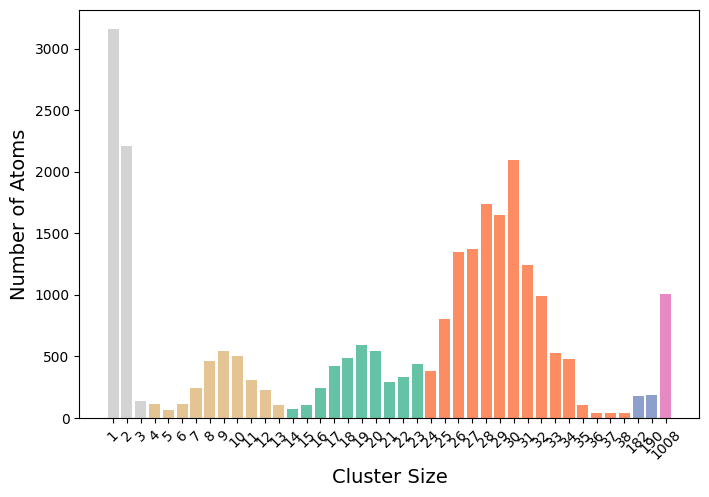

In [57]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example cluster_size_counts DataFrame for demonstration purposes
# Remove this if you already have your DataFrame
# df = pd.DataFrame({'cluster_size': np.random.randint(1, 1010, 1000)})

cluster_size_counts = df['cluster_size'].value_counts().sort_index(ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
bar_positions = np.arange(len(cluster_size_counts))
hex_colors = ['#D3D3D3', '#e5c494','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854' ]
# Define the color for each range
def get_color(cluster_size):
    if 1 <= cluster_size <= 3:
        return hex_colors[0]
    elif 4 <= cluster_size <= 13:
        return hex_colors[1]
    elif 14 <= cluster_size <= 23:
        return hex_colors[2]
    elif 24 <= cluster_size <= 38:
        return hex_colors[3]
    elif 182 <= cluster_size <= 190:
        return hex_colors[4]
    elif cluster_size == 1008:
        return hex_colors[5]
    else:
        return hex_colors[6] # default color for other sizes

# Apply the colors to the bars
bar_colors = [get_color(size) for size in cluster_size_counts.index]

ax.bar(bar_positions, cluster_size_counts.values, color=bar_colors)

ax.set_xticks(bar_positions)
ax.set_xticklabels(cluster_size_counts.index.astype(str), rotation=45)

# Customize the plot
ax.set_xlabel('Cluster Size', fontsize=14)
ax.set_ylabel('Number of Atoms', fontsize=14)
# ax.set_title('Distribution of Cluster Sizes')

plt.subplots_adjust(bottom=0.2)
plt.savefig('Distribution_of_atoms.pdf', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

#### 3&4. Data Pruning & Potential Fitting for GAE Clusters of Different Sizes

This section investigates the impact of cluster size of the data pruning on potential fitting performance. We prune data from GAE clusters within specific size ranges while keeping unselected clusters intact. The pruning process involves randomly removing a fraction of data points from each cluster. We fit the potential using the pruned dataset and evaluate the performance metrics. By repeating this process for different size ranges and pruning fractions, we analyze the relationship between cluster size and potential fitting accuracy.


In [58]:
#select the cluster sizes larger than 10 for pruning
cluster_size_limit_num=sorted(zip(cluster_size_limit_pair,cluster_size_num_atoms))
size_limit_pair=[i for i,j in cluster_size_limit_num if i[0] >= 10]
size_num_atoms=[j for i,j in cluster_size_limit_num if i[0] >= 10]

In [59]:
def pruning_diffsize(size_limit_l, size_limit_r):
    idx_type = 'cluster_idx'
    
    # Filter dataframe based on cluster size range
    filtered_size_df = df[(df['cluster_size'] >= size_limit_l) & (df['cluster_size'] <= size_limit_r)]
    
    # Group the filtered dataframe by cluster index
    grouped_filtered = filtered_size_df.groupby(idx_type)
    
    def sampling(frac):
        # Randomly remove a fraction of data points from each group
        remove_indices = []
        for _, group_data in grouped_filtered:
            remove_indices.extend(group_data.sample(frac=frac).index)
        
        # Keep the data points that were not removed
        keep_data_df = df[~df.index.isin(remove_indices)]
        return keep_data_df
    
    mse_test_ave_list, mse_test_std_list = [], []
    # group_name_init_list, group_name_fin_list = [], []
    keep_num_ave_list = []
    
    ridge_model = Ridge(alpha=alpha)
    
    frac_list = [0.1 * i for i in range(0, 11)]
    
    for frac in frac_list:
        mse_test_list,keep_num_list = [], []

        #Perform 20 random sampling iterations at each pruning fraction to ensure robustness.
        for i in range(20):
            # Sample the data using the specified fraction
            filtered_df = sampling(frac)
            
            # Prepare the features and target variable for training

            filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()

            X_train = np.vstack([filtered_df_feats[:, :num_feats],
                        filtered_df_feats[:, num_feats:num_feats*2],
                        filtered_df_feats[:, num_feats*2:num_feats*3]])
            y_train = pd.concat([filtered_df['forcex_truths'],
                        filtered_df['forcey_truths'],
                        filtered_df['forcez_truths']], axis=0)

            ridge_model.fit(X_train, y_train)
            # Predict on the test set and calculate MSE
            y_pred_test = ridge_model.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
            
            mse_test_list.append(mse_test)
            keep_num_list.append(len(filtered_df))
            
            # Store group names for initial and final fractions
            # if frac == frac_list[0]:
            #     group_name_init_list.append(filtered_df['Groups'].values)
            # if frac == frac_list[-1]:
            #     group_name_fin_list.append(filtered_df['Groups'].values)
        
        # Calculate average and standard deviation of MSE and save the number of remaining atoms
        mse_test_ave_list.append(np.mean(np.array(mse_test_list)))
        mse_test_std_list.append(np.std(np.array(mse_test_list)))
        keep_num_ave_list.append(np.mean(np.array(keep_num_list)))
    
    return mse_test_ave_list, mse_test_std_list, keep_num_ave_list

- Training Data Pruning Based on Cluster Size. The pruning fractions range from 0% to 100% with a step size of 10%.

In [60]:
# Define the size range pairs for pruning

GAE_mse_ave_list,GAE_mse_std_list,GAE_keep_num_list=[],[],[]
for size_limit_l,size_limit_r in size_limit_pair:
    mse_test_ave_list,mse_test_std_list,keep_num_ave_list=pruning_diffsize(size_limit_l,size_limit_r)
    GAE_mse_ave_list.append(mse_test_ave_list)
    GAE_mse_std_list.append(mse_test_std_list)
    GAE_keep_num_list.append(keep_num_ave_list)

#### Plot the results

Test errors for MEAGraph pruning of different cluster size ranges

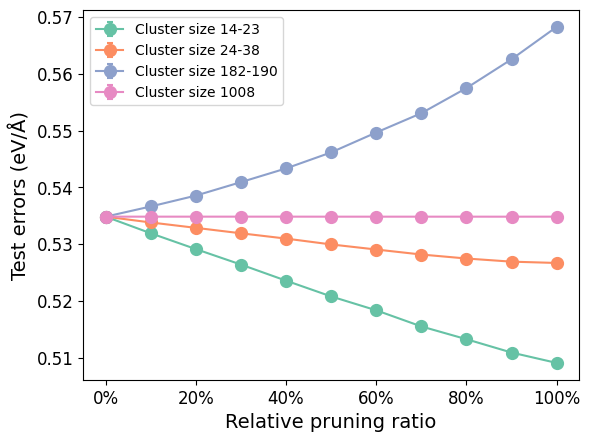

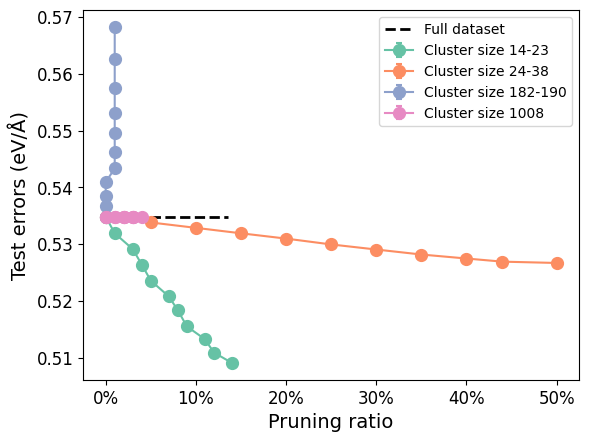

In [61]:
#In this plot, the pruning ratio on the x-axis is the fraction of atoms being removed from clusters within a certain size range

from matplotlib.ticker import FuncFormatter
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'
   # return f'{x * 100}%'

size = []
colors = []

# Create a color palette
import matplotlib.pyplot as plt
palette = plt.get_cmap('Set2')  # You can choose a different colormap if desired

for i, size_range in enumerate(size_limit_pair):
    if size_range[0]==size_range[1]:
        size.append(f"{size_range[0]}")
    else:
        size.append(f"{size_range[0]}-{size_range[1]}")
#    colors.append(palette(i / len(size_limit_pair)))  # Assign colors from the color palette

colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
fig, ax = plt.subplots()

for i in range(len(GAE_keep_num_list)):

    pruning_frac= [0.1 * i for i in range(0, 11)]
    mse_test_ave_list = GAE_mse_ave_list[i]
    mse_test_std_list = GAE_mse_std_list[i]
    
    ax.errorbar(
        pruning_frac,
        np.array(mse_test_ave_list),
        yerr=np.array(mse_test_std_list),
        label=f'Cluster size {size[i]}',
        marker='o',
        linestyle='-',
        color=colors[i % len(colors)],  # Cycle through colors
        capsize=2,
        elinewidth=0.5,
        markeredgewidth=1.5,
        markersize=8
    )

plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
pruning_frac=[round((len(df)-keep_num)/len(df),4) for keep_num in GAE_keep_num_list[2]]
# plt.plot(pruning_frac,[mse_test_ave_list[0]]*len(pruning_frac),color='black',linestyle='--',linewidth=2,label='full dataset')


#plt.legend()
plt.legend(loc='upper left')
#plt.ylim(5.5,8.5)
plt.xlabel('Relative pruning ratio',fontsize=14)
plt.ylabel('Test errors (eV/Å)',fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.savefig('Pruning_Fe_wrtClusters.pdf',dpi=600,bbox_inches='tight')
#In this plot, the pruning ratio on the x-axis represents the number of removed atoms divided by the total number of atoms in the dataset.

from matplotlib.ticker import FuncFormatter
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'
   # return f'{x * 100}%'



fig, ax = plt.subplots()


for i in range(len(GAE_keep_num_list)):

    pruning_frac=[round((len(df)-keep_num)/len(df),2) for keep_num in GAE_keep_num_list[i]]
    mse_test_ave_list = GAE_mse_ave_list[i]
    mse_test_std_list = GAE_mse_std_list[i]
    
    ax.errorbar(
        pruning_frac,
        np.array(mse_test_ave_list),
        yerr=np.array(mse_test_std_list),
        label=f'Cluster size {size[i]}',
        marker='o',
        linestyle='-',
        color=colors[i % len(colors)],  # Cycle through colors
        capsize=2,
        elinewidth=0.5,
        markeredgewidth=1.5,
        markersize=8
    )

plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
pruning_frac=[round((len(df)-keep_num)/len(df),4) for keep_num in GAE_keep_num_list[0]]
plt.plot(pruning_frac,[mse_test_ave_list[0]]*len(pruning_frac),color='black',linestyle='--',linewidth=2,label='Full dataset')


#plt.legend()
plt.legend(loc='upper right')
#plt.ylim(5.5,8.5)
plt.xlabel('Pruning ratio',fontsize=14)
plt.ylabel('Test errors (eV/Å)',fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.savefig('Pruning_Fe_wrtDatasets.pdf',dpi=600,bbox_inches='tight')

- Histogram Distribution of Atoms in Selected Cluster Size Ranges.
 
The histograms show the number of atoms falling into each cluster size range. The histogram bars are stacked together to represent the distribution of atoms in the entire training dataset.

[(1, 3), (4, 13), (14, 23), (24, 38), (182, 190), (1008, 1008)]


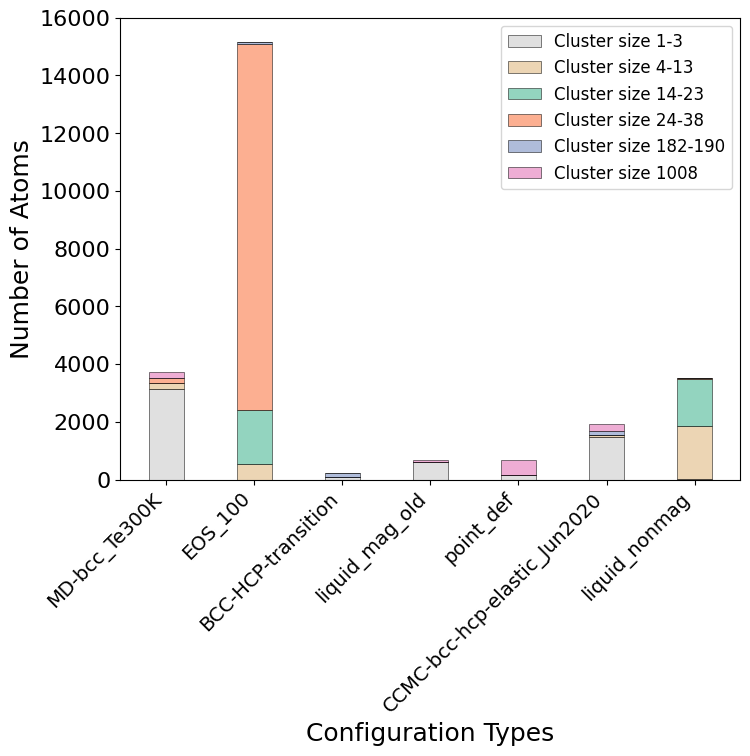

In [62]:

from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#add the cluster size below 10
#size_limit_pair_full=size_limit_pair+[(1,14)]
size_limit_pair_full=[(1,3),(4,13)]+size_limit_pair
print(size_limit_pair_full)
size = []
colors = []
# Create a color palette
import matplotlib.pyplot as plt
 # You can choose a different colormap if desired

for i, size_range in enumerate(size_limit_pair_full):
    if size_range[0]==size_range[1]:
        size.append(f"{size_range[0]}")
    else:
        size.append(f"{size_range[0]}-{size_range[1]}")
    # colors.append(palette(i / len(size_limit_pair_full)))  # Assign colors from the color palette

colors=['#D3D3D3', '#e5c494','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854' ]
group_name_filtered_list=[]
for size_limit_l,size_limit_r in size_limit_pair_full:
    filtered_size_df = df[(df['cluster_size'] >= size_limit_l) & (df['cluster_size'] <= size_limit_r)]
    group_name_filtered_list.append(filtered_size_df['Groups'].values)



def update_stats(group_name_filtered):
    stats_groups = defaultdict(list)
    count_dict = Counter(group_name_filtered)
    for name, count in count_dict.items():
        stats_groups[name] = count
    return stats_groups


fig, ax = plt.subplots(figsize=(8, 6))


bar_width = 0.4
opacity = 0.7

group_names = ['MD-bcc_Te300K', 'EOS_100', 'BCC-HCP-transition', 'liquid_mag_old', 'point_def', 'CCMC-bcc-hcp-elastic_Jun2020', 'liquid_nonmag']
column_order = group_names


x = np.arange(len(group_names))





df_cumulative = pd.DataFrame(columns=group_names, index=range(len(group_name_filtered_list)))

for i, group_name_filtered in enumerate(group_name_filtered_list):
    stats_groups = update_stats(group_name_filtered)
    df_stats_groups = pd.DataFrame.from_dict(stats_groups, orient='index').transpose()
    df_stats_groups = df_stats_groups.reindex(columns=group_names)
    df_stats_groups.fillna(0, inplace=True)


    df_cumulative.iloc[i] = df_stats_groups.iloc[0]


df_cumulative = df_cumulative.cumsum()


for i, group_name_filtered in enumerate(group_name_filtered_list):
    if i == 0:
        bottom = np.zeros(len(group_names))
    else:
        bottom = df_cumulative.iloc[i - 1]

    ax.bar(x, df_cumulative.iloc[i] - bottom, bar_width, bottom=bottom,
           alpha=opacity, color=colors[i % len(colors)], edgecolor='black',linewidth=0.5, label=f'Cluster size {size[i]}')


ax.set_xticks(x)
ax.set_xticklabels(group_names, fontsize=14)

#ax.set_yscale('log')
# Set more dense ticks for y-axis
# start, end = ax.get_ylim()
# ax.yaxis.set_ticks(np.logspace(np.log10(start), np.log10(end), num=10))
# ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
# ax.set_xlabel('Group Labels', fontsize=16)
# ax.set_ylabel('Number of Atoms', fontsize=16)

ax.set_xlabel('Configuration Types', fontsize=18)
ax.set_ylabel('Number of Atoms', fontsize=18)
ax.legend(fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=16)
plt.ylim(0,16000)
# plt.tight_layout()
plt.savefig('group_stats.pdf',dpi=600,bbox_inches='tight')
# plt.show()

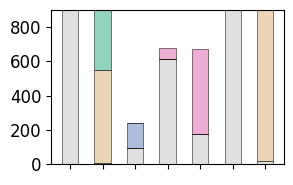

In [63]:

#The inset figure to check distribution of atoms below 1000
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# size_limit_pair.remove((0,10))
size = []
colors=['#D3D3D3', '#e5c494','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854' ]
# Create a color palette
import matplotlib.pyplot as plt
palette = plt.get_cmap('Set2')  # You can choose a different colormap if desired

for i, size_range in enumerate(size_limit_pair_full):
    if size_range[0]==size_range[1]:
        size.append(f"{size_range[0]}")
    else:
        size.append(f"{size_range[0]}-{size_range[1]}")
    # colors.append(palette(i / len(size_limit_pair_full)))  # Assign colors from the color palette


group_name_filtered_list=[]
for size_limit_l,size_limit_r in size_limit_pair_full:
    filtered_size_df = df[(df['cluster_size'] >= size_limit_l) & (df['cluster_size'] <= size_limit_r)]
    group_name_filtered_list.append(filtered_size_df['Groups'].values)



def update_stats(group_name_filtered):
    stats_groups = defaultdict(list)
    count_dict = Counter(group_name_filtered)
    for name, count in count_dict.items():
        stats_groups[name] = count
    return stats_groups


fig, ax = plt.subplots(figsize=(3, 2))


bar_width = 0.5
opacity = 0.7

group_names = ['MD-bcc_Te300K', 'EOS_100', 'BCC-HCP-transition', 'liquid_mag_old', 'point_def', 'CCMC-bcc-hcp-elastic_Jun2020', 'liquid_nonmag']
column_order = group_names


x = np.arange(len(group_names))

df_cumulative = pd.DataFrame(columns=group_names, index=range(len(group_name_filtered_list)))

for i, group_name_filtered in enumerate(group_name_filtered_list):
 
    stats_groups = update_stats(group_name_filtered)
    df_stats_groups = pd.DataFrame.from_dict(stats_groups, orient='index').transpose()
    df_stats_groups = df_stats_groups.reindex(columns=group_names)
    df_stats_groups.fillna(0, inplace=True)


    df_cumulative.iloc[i] = df_stats_groups.iloc[0]


df_cumulative = df_cumulative.cumsum()



for i, group_name_filtered in enumerate(group_name_filtered_list):
    if i == 0:
        bottom = np.zeros(len(group_names))
    else:
        bottom = df_cumulative.iloc[i - 1]

    ax.bar(x, (df_cumulative.iloc[i] - bottom).to_numpy(), bar_width, bottom=bottom,
           alpha=opacity, color=colors[i % len(colors)], edgecolor='black',linewidth=0.5, label=f'Cluster size {size[i]}')


ax.set_xticks(x)
ax.set_xticklabels(group_names, fontsize=9)
# ax.set_yscale('log')
ax.set_xticklabels([])  # Remove x-tick labels

# ax.set_xlabel('Group Labels', fontsize=16)
# ax.set_ylabel('Number of Atoms', fontsize=16)

#ax.set_xlabel('Group Labels', fontsize=18)
# ax.set_ylabel('Number of Atoms', fontsize=18)


plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.ylim(0,900)
# plt.tight_layout()
plt.savefig('group_stats_inset.pdf',dpi=600,bbox_inches='tight')
# plt.show()

#### 5. Pruning atoms in cluster size ranges containing a large number of atoms

Here we select the `size_threshold` as 1000 to prune the atoms with cluster size in the range of (14,23), (23,38) and (1008) (which covers > 1000 atoms) and compare the pruning effect with random pruning and other pruning method based on DBSCAN and AffinityPropagation clustering.

In [64]:

size_threshold = 1000
screen_index=np.where(np.array(size_num_atoms)> size_threshold)[0]
size_limit_pair_prune=[j for i,j in enumerate(size_limit_pair) if i in screen_index ]
size_limit_pair_prune

[(14, 23), (24, 38), (1008, 1008)]

In [65]:
def pruning_diffsize(size_limit_pair_prune):
    idx_type = 'cluster_idx'
    filtered_size_dfs = [df[(df['cluster_size'] >= size_limit_l) & (df['cluster_size'] <= size_limit_r)] for size_limit_l, size_limit_r in size_limit_pair_prune]
    filtered_size_df = pd.concat(filtered_size_dfs)
   # filtered_size_df=filtered_size_df[filtered_size_df['Groups']!='liquid_nonmag']
    # Group the filtered dataframe by cluster index
    grouped_filtered = filtered_size_df.groupby(idx_type)
    
    def sampling(frac):
        # Randomly remove a fraction of data points from each group
        remove_indices = []
        for _, group_data in grouped_filtered:
            remove_indices.extend(group_data.sample(frac=frac).index)
        
        # Keep the data points that were not removed
        keep_data_df = df[~df.index.isin(remove_indices)]
        return keep_data_df
    
    mse_test_ave_list, mse_test_std_list = [], []
    group_name_init_list, group_name_fin_list = [], []
    keep_num_ave_list = []
    
    ridge_model = Ridge(alpha=alpha)
    
    #fraction from 0% to 90%
    frac_list = [0.1 * i for i in range(0, 11)]
    
    for frac in frac_list:
        mse_test_list,keep_num_list = [], []

        #Perform 20 random sampling iterations at each pruning fraction to ensure robustness.
        for i in range(20):
            # Sample the data using the specified fraction
            filtered_df = sampling(frac)
            
            # Prepare the features and target variable for training
  
            filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()

            X_train = np.vstack([filtered_df_feats[:, :num_feats],
                        filtered_df_feats[:, num_feats:num_feats*2],
                        filtered_df_feats[:, num_feats*2:num_feats*3]])
            y_train = pd.concat([filtered_df['forcex_truths'],
                        filtered_df['forcey_truths'],
                        filtered_df['forcez_truths']], axis=0)

            ridge_model.fit(X_train, y_train)

            
            # Predict on the test set and calculate MSE
            y_pred_test = ridge_model.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
            
            mse_test_list.append(mse_test)
            keep_num_list.append(len(filtered_df))
            
            # Store group names for initial and final fractions
            if frac == frac_list[0]:
                group_name_init_list.append(filtered_df['Groups'].values)
            if frac == frac_list[-1]:
                group_name_fin_list.append(filtered_df['Groups'].values)
        
        # Calculate average and standard deviation of MSE and save the number of remaining atoms
        mse_test_ave_list.append(np.mean(np.array(mse_test_list)))
        mse_test_std_list.append(np.std(np.array(mse_test_list)))
        keep_num_ave_list.append(np.mean(np.array(keep_num_list)))
    
    return mse_test_ave_list, mse_test_std_list, keep_num_ave_list,group_name_init_list,group_name_fin_list

- Pruning with MEAGraph for atoms in cluster size ranges of [(14, 23), (24, 38), (1008, 1008)]

In [66]:

#pruning with GAE
mse_test_ave_list,mse_test_std_list,keep_num_ave_list,group_name_init_list,group_name_fin_list=pruning_diffsize(size_limit_pair_prune)

- Apply random pruning with the same number of atoms removed as MEAGraph at each pruning ratio

In [67]:
#random pruning
random_mse_test_ave_list,random_mse_test_std_list=[],[]

ridge_model = Ridge(alpha=alpha)
# random.seed(0)
random_group_name_fin_list=[]
for count,keep_num in enumerate(keep_num_ave_list):
    random_mse_test_list,random_mse_train_list=[],[]
    for i in range(20):
        filtered_df=df.sample(n=int(keep_num))
    
        filtered_df_feats=filtered_df.iloc[:,1:num_feats*3+1].to_numpy()

        X_train = np.vstack([filtered_df_feats[:, :num_feats],
                     filtered_df_feats[:, num_feats:num_feats*2],
                     filtered_df_feats[:, num_feats*2:num_feats*3]])
        y_train = pd.concat([filtered_df['forcex_truths'],
                     filtered_df['forcey_truths'],
                     filtered_df['forcez_truths']], axis=0)

        ridge_model.fit(X_train, y_train)
        y_pred_test = ridge_model.predict(X_test)
        random_mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
        random_mse_test_list.append(random_mse_test)
        if count == len(keep_num_ave_list)-1:
            random_group_name_fin_list.append(filtered_df['Groups'].values)

    random_mse_test_ave_list.append(np.mean(np.array(random_mse_test_list)))
    random_mse_test_std_list.append(np.std(np.array(random_mse_test_list)))


- Compare the test errors of the force field model trained on the Fe dataset after pruning atomic clusters in four size ranges: 14-23 atoms (green), 24-38 atoms (orange), 1008 atoms (magenta), and 182-190 atoms (blue). The red line shows test error variations when pruning is applied across the first three groups combined, compared to random pruning (black), where the same number of atoms is removed. The relative pruning ratio indicates the proportion of atoms removed from the total number in the targeted clusters.

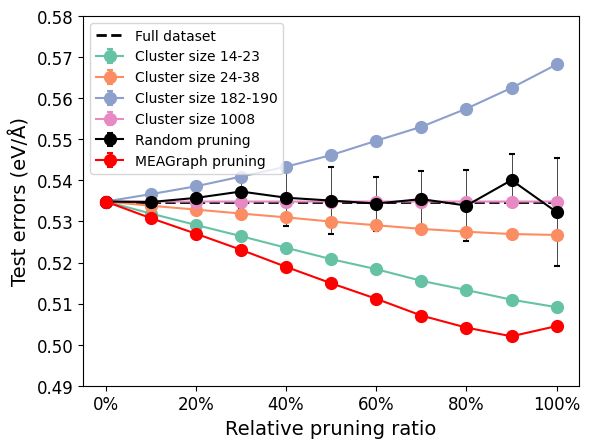

In [68]:

#In this plot, the pruning ratio on the x-axis is the fraction of atoms being removed from clusters within a certain size range

from matplotlib.ticker import FuncFormatter
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'
   # return f'{x * 100}%'

size = []
colors = []

# Create a color palette
import matplotlib.pyplot as plt
# palette = plt.get_cmap('Set2')  # You can choose a different colormap if desired

for i, size_range in enumerate(size_limit_pair):
    if size_range[0]==size_range[1]:
        size.append(f"{size_range[0]}")
    else:
        size.append(f"{size_range[0]}-{size_range[1]}")
#    colors.append(palette(i / len(size_limit_pair)))  # Assign colors from the color palette

colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
fig, ax = plt.subplots()

for i in range(len(GAE_keep_num_list)):

    pruning_frac= [0.1 * i for i in range(0, 11)]
    c_mse_test_ave_list = GAE_mse_ave_list[i]
    c_mse_test_std_list = GAE_mse_std_list[i]
    
    ax.errorbar(
        pruning_frac,
        np.array(c_mse_test_ave_list),
        yerr=np.array(c_mse_test_std_list),
        label=f'Cluster size {size[i]}',
        marker='o',
        linestyle='-',
        color=colors[i % len(colors)],  # Cycle through colors
        capsize=2,
        elinewidth=0.5,
        markeredgewidth=1.5,
        markersize=8
    )

pruning_frac=[i*0.1 for i in range(11)]

ax.errorbar(
    pruning_frac,
    np.array(random_mse_test_ave_list),
    yerr=np.array(random_mse_test_std_list),
    marker='o',
    linestyle='-',
    label=f'Random pruning',
    color='black',  # Cycle through colors
    capsize=2,
    elinewidth=0.5,
    markeredgewidth=1.5,
    markersize=8
)


ax.errorbar(
    pruning_frac,
    np.array(mse_test_ave_list),
    yerr=np.array(mse_test_std_list),
    label=f'MEAGraph pruning',
    marker='o',
    linestyle='-',
    color='red',  # Cycle through colors
    capsize=2,
    elinewidth=0.5,
    markeredgewidth=1.5,
    markersize=8
)

plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.plot(pruning_frac,[mse_test_ave_list[0]]*len(pruning_frac),color='black',linestyle='--',linewidth=2,label='Full dataset')
plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.legend(loc='upper left')
plt.ylim(0.49,0.58)
plt.xlabel('Relative pruning ratio',fontsize=14)
plt.ylabel('Test errors (eV/Å)',fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.savefig('Pruning_Fe_wrtClusters_all.pdf',dpi=600,bbox_inches='tight')

- Comparison of test errors using four pruning methods: MEAGraph, DBSCAN, Affinity Propagation, and random pruning.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
def sampling_test(df,data, rate, train_val_ratio, num_feats, X_test, y_test, alpha, clustering_method='AffinityPropagation', pca_transform=False, scaler_transform=True,eps=1):
    """
    Perform sampling test using different clustering methods and evaluate the performance.

    Args:
        df (pandas.DataFrame): Input dataframe containing atom information.
        data: Input data object containing feature matrix.
        rate (float): Rate parameter for sampling.
        train_val_ratio (float): Ratio of training data to validation data.
        num_feats (int): Number of features.
        X_test (numpy.ndarray): Test feature matrix.
        y_test (numpy.ndarray): Test target values.
        alpha (float): Regularization parameter for Ridge regression.
        clustering_method (str): Clustering method to use ('AffinityPropagation' or 'DBSCAN').
        pca_transform (bool): Whether to apply PCA transformation.
        eps (float): Epsilon parameter for DBSCAN.
    Returns:
        tuple: Three lists containing average MSE, standard deviation of MSE, and average number of kept data points.
    """
    ap_labels_path = f'{results_dir}/{clustering_method.lower()}_labels_r{rate}_train{train_val_ratio}.npy'
    
    # if not os.path.exists(ap_labels_path):
    
    if scaler_transform:
        scaler=StandardScaler()
        data_x=scaler.fit_transform(data.x)
    if pca_transform:
        num_components = 10
        pca = PCA(n_components=num_components)
        transformed_data = pca.fit_transform(data_x)
        if clustering_method == 'AffinityPropagation':
            if not os.path.exists(ap_labels_path):
                clusters = AffinityPropagation().fit(transformed_data)
        elif clustering_method == 'DBSCAN':
            clusters = DBSCAN().fit(transformed_data)
        #    clusters = DBSCAN(eps=eps).fit(transformed_data)
        elif clustering_method == 'mean_shift':
            bandwidth=2
            mean_shift = MeanShift(bandwidth=bandwidth)
            labels = mean_shift.fit_predict(transformed_data)
        # elif clustering_method == ''
        else: pass
    else:
        if clustering_method == 'AffinityPropagation':
            if not os.path.exists(ap_labels_path):
                clusters = AffinityPropagation().fit(data_x)
        else:
       
            clusters = DBSCAN().fit(data_x)
    
    # np.save(ap_labels_path, clusters.labels_)
    
    labels = np.load(ap_labels_path)
    df_ap_info = pd.DataFrame({'cluster_ap_idx': labels})
    cluster_sizes = df_ap_info['cluster_ap_idx'].value_counts()
    df_ap_info['cluster_ap_size'] = df_ap_info['cluster_ap_idx'].map(cluster_sizes)
    df_ap_info.reset_index(inplace=True)
    df_ap_info.rename(columns={'index':'Atom_ID'},inplace=True)
    df_ap=pd.merge(df,df_ap_info,on='Atom_ID')
    
    
    idx_type = 'cluster_ap_idx'

    filtered_size_ap_df = df_ap[df_ap['cluster_ap_size'] > 10]
    grouped_ap_filtered = filtered_size_ap_df.groupby(idx_type)


    def sampling(frac):
        remove_indices = []
        for _, group_data in grouped_ap_filtered:
            remove_indices.extend(group_data.sample(frac=frac).index)
        keep_data_df = df_ap[~df_ap.index.isin(remove_indices)]
        return keep_data_df
    
    ap_mse_test_ave_list, ap_mse_test_std_list = [], []
    ap_keep_num_ave_list = []
    ridge_model_test = Ridge(alpha=alpha)
    frac_ap_list = [0.1 * i for i in range(0, 10)]
    for frac in frac_ap_list:
        ap_mse_test_list, ap_keep_num_list = [], []
        
        for i in range(20):
            filtered_df = sampling(frac)
            filtered_df_feats = filtered_df.iloc[:, 1:num_feats*3+1].to_numpy()
            X_train = np.vstack([filtered_df_feats[:, :num_feats],
                                 filtered_df_feats[:, num_feats:num_feats*2],
                                 filtered_df_feats[:, num_feats*2:num_feats*3]])
            y_train = pd.concat([filtered_df['forcex_truths'],
                                 filtered_df['forcey_truths'],
                                 filtered_df['forcez_truths']], axis=0)

   
            
            ridge_model_test.fit(X_train, y_train)
            y_pred_test = ridge_model_test.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test,squared=False)
            ap_mse_test_list.append(mse_test)
            ap_keep_num_list.append(len(filtered_df))
        
        ap_mse_test_ave_list.append(np.mean(np.array(ap_mse_test_list)))
        ap_mse_test_std_list.append(np.std(np.array(ap_mse_test_list)))
        ap_keep_num_ave_list.append(np.mean(np.array(ap_keep_num_list)))
    
    return ap_mse_test_ave_list, ap_mse_test_std_list, ap_keep_num_ave_list

In [ ]:
db_mse_test_ave_list, db_mse_test_std_list, db_keep_num_ave_list = sampling_test(
    df,traindata, rate, train_val_ratio, num_feats, X_test, y_test, alpha, 
    clustering_method='DBSCAN', pca_transform=True,scaler_transform=True)

In [ ]:
##it takes quite a while
# ap_mse_test_ave_list, ap_mse_test_std_list, ap_keep_num_ave_list = sampling_test(
#     df,traindata, rate, train_val_ratio, num_feats, X_test, y_test, alpha, 
#     clustering_method='AffinityPropagation', pca_transform=True,scaler_transform=True)

In [ ]:
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

def percentage_formatter(x, pos):
    return f'{int(x * 100)}%'
pruning_frac=[round((len(df)-keep_num)/len(df),2) for keep_num in keep_num_ave_list]
# pruning_frac_ap=[round((len(df)-keep_num)/len(df),2) for keep_num in ap_keep_num_ave_list][:-2]
pruning_frac_db=[round((len(df)-keep_num)/len(df),2) for keep_num in db_keep_num_ave_list][:-1]
plt.plot(figsize=(8,6))
plt.errorbar(
    pruning_frac,
    np.array(random_mse_test_ave_list),
    yerr=np.array(random_mse_test_std_list),
    label='Random pruning',
    marker='o',
    linestyle='-', 
    color='blue',
    capsize=2,  # Size of error bar caps
    elinewidth=0.5,  # Width of error bar lines
    markeredgewidth=1.5,  # Width of marker edge
    markersize=8,  # Size of markers
)
plt.errorbar(
    pruning_frac,
    np.array(mse_test_ave_list),
    yerr=np.array(mse_test_std_list),
    label='MEAGraph pruning',
    marker='o',
    linestyle='-', 
    color='red',
    capsize=2,  
    elinewidth=0.5,  
    markeredgewidth=1.5, 
    markersize=8,  
)

plt.errorbar(
    pruning_frac_db,
    np.array(db_mse_test_ave_list)[:-1],
    yerr=np.array(db_mse_test_std_list)[:-1],
    label='DBSCAN pruning',
    marker='o',
    linestyle='-', 
    color='lightgreen',
    capsize=2,  
    elinewidth=0.5,  
    markeredgewidth=1.5, 
    markersize=8, 
)

# plt.errorbar(
#     pruning_frac_ap,
#     np.array(ap_mse_test_ave_list)[:-2],
#     yerr=np.array(ap_mse_test_std_list)[:-2],
#    # label='AP pruning',
#     label='AffinityProp pruning',
#     marker='o',
#     linestyle='-', 
#     color='lightsalmon',
#     capsize=2, 
#     elinewidth=0.5, 
#     markeredgewidth=1.5, 
#     markersize=8,  
# )

plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
# Set the y-axis formatter to display three digits
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(pruning_frac,[mse_test_ave_list[0]]*len(pruning_frac),color='black',linestyle='--',linewidth=2,label='Full dataset')


plt.legend()
# plt.ylim(0.5,0.58)
# plt.ylim(0.115,0.122)
#plt.xlim(0,0.2)
plt.xlabel('Pruning ratio',fontsize=14)
plt.ylabel('Test errors (eV/Å)',fontsize=14)
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('pruning_Ta.pdf',dpi=600,bbox_inches='tight')
plt.savefig('pruning_Fe_compareDiffCluster_transparent.pdf',dpi=600,bbox_inches='tight',transparent=True)